In [1]:
import math
from datetime import datetime as dt
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import eviltransform
import pytz



We choose not to use the `driver_id` information (interpreting as having little information not already found in `order_id`), so we drop that column to save memory.

Timestamps are also provided in Unix Epoch time and need to be converted to local time ("Asia/Shanghai" or UTC+8).

In [2]:
%%time
dfo = pd.read_csv('gps_20161201')
dfo.drop(columns=['driver_id'], inplace=True)
dfo['timestamp'] = pd.to_datetime(dfo['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')

CPU times: user 18.1 s, sys: 7.03 s, total: 25.1 s
Wall time: 20.4 s


In [3]:
dfo.head()

,order_id,timestamp,longitude,latitude
0,qqhv4gjoujozzttq2qtmprqj1drqnpqF,2016-12-01 08:28:52+08:00,108.91161,34.22883
1,qqhv4gjoujozzttq2qtmprqj1drqnpqF,2016-12-01 08:29:01+08:00,108.91217,34.22966
2,qqhv4gjoujozzttq2qtmprqj1drqnpqF,2016-12-01 08:29:04+08:00,108.91237,34.22996
3,qqhv4gjoujozzttq2qtmprqj1drqnpqF,2016-12-01 08:28:58+08:00,108.91199,34.22939
4,qqhv4gjoujozzttq2qtmprqj1drqnpqF,2016-12-01 08:29:13+08:00,108.91296,34.23081


We check the distribution of datapoints throughout the day.

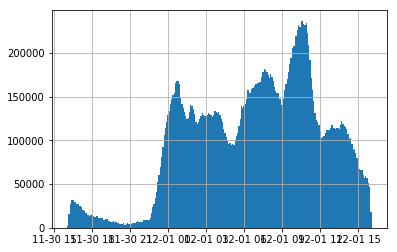

In [4]:
dfo['timestamp'].hist(bins=240)
plt.show()

Let's grab the dataset longitude and latitude boundaries for use later.

In [5]:
lonmin = dfo['longitude'].min()
lonmax = dfo['longitude'].max()
latmin = dfo['latitude'].min()
latmax = dfo['latitude'].max()
print(lonmin, lonmax, latmin, latmax)

108.91118999999999 108.9986 34.20531 34.28021


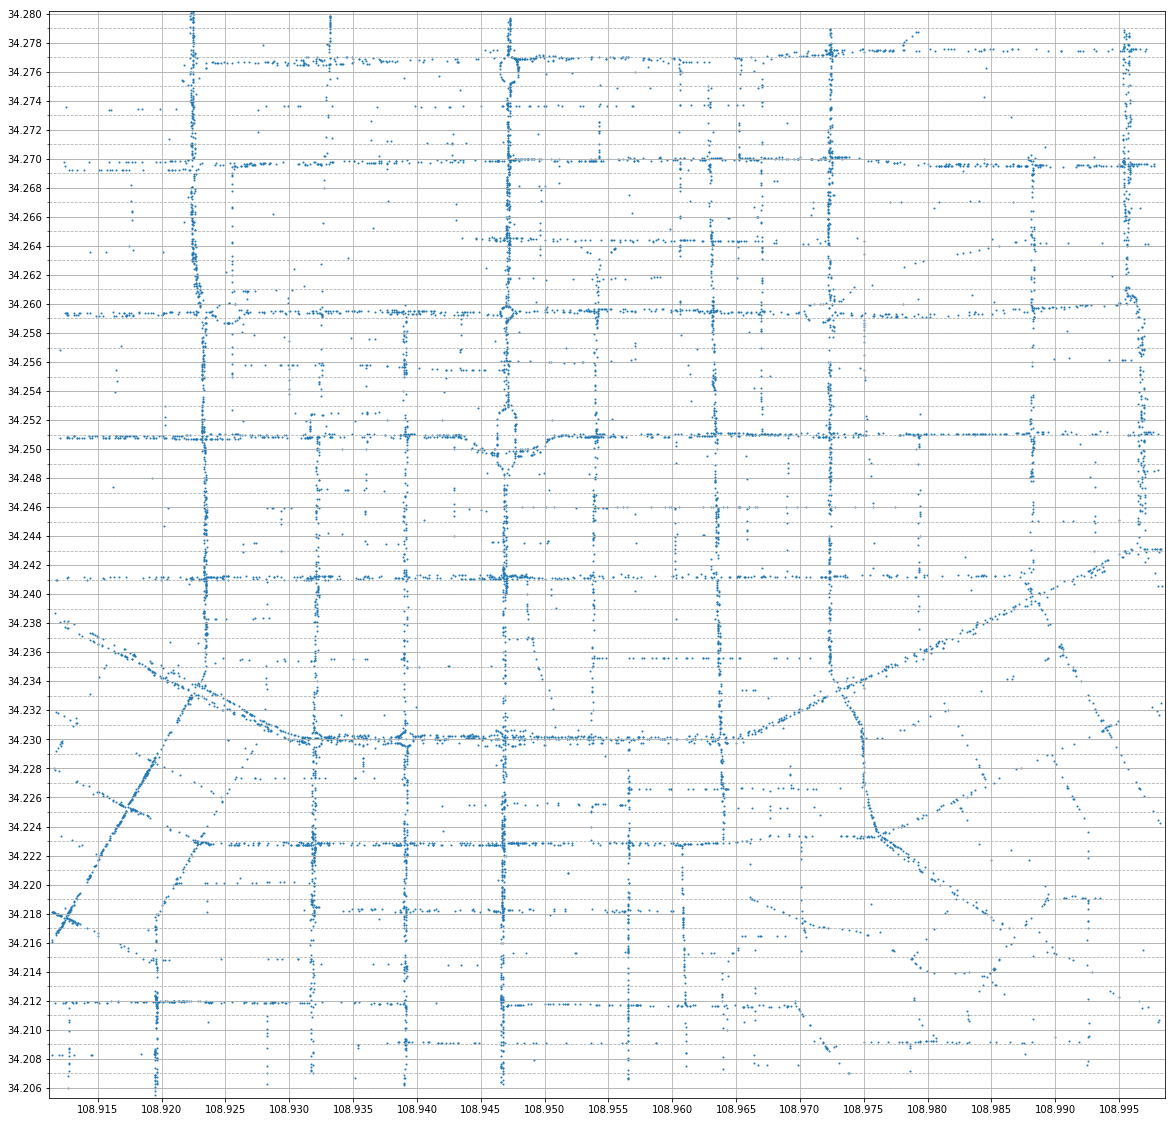

In [6]:
def plot_all(df):
    plt.figure(figsize=(20,20))
    plt.scatter(df['longitude'],df['latitude'], s=1)
    del df
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.grid(b=True, which='major')
    ax.yaxis.set_major_locator(plticker.MultipleLocator(base=0.002))
    ax.yaxis.set_minor_locator(plticker.MultipleLocator(base=0.001))
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=0.005))
    # ax.xaxis.set_minor_locator(plticker.MultipleLocator(base=0.005))
    plt.axis([lonmin, lonmax, latmin, latmax])
    ax.grid(b=True, which='minor', linestyle='--')
    plt.show()

plot_all(dfo.sample(10_000))

## Check study time periods

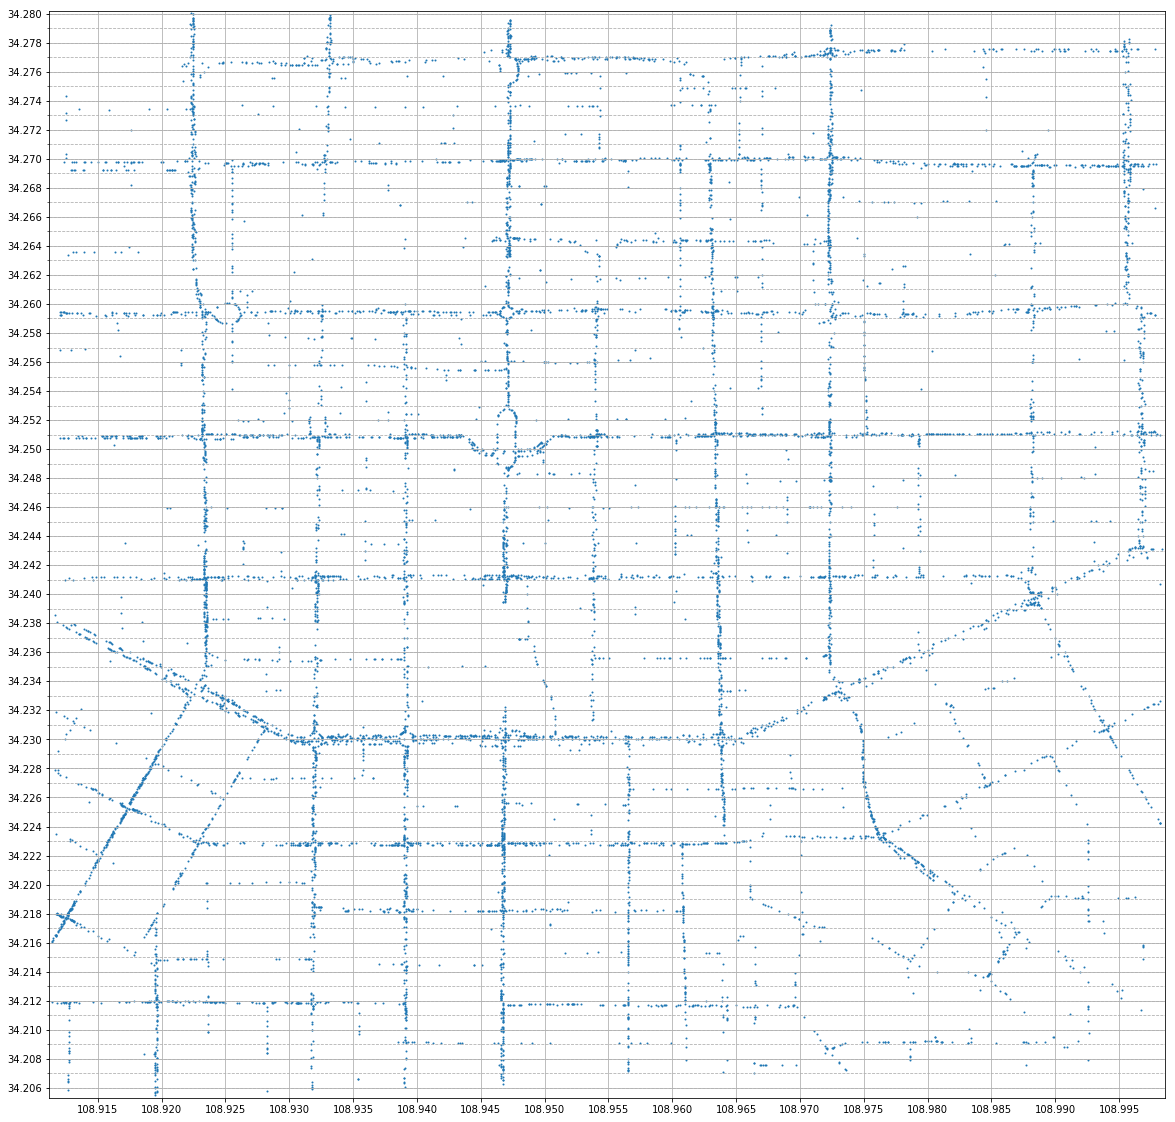

In [349]:
plot_all(dfo.loc[
    ((dfo['timestamp'].dt.hour >=  6) & (dfo['timestamp'].dt.hour < 11)) | 
    ((dfo['timestamp'].dt.hour >= 16) & (dfo['timestamp'].dt.hour < 21))
    , :
].sample(10_000))

# Addressing coordinate systems

Didi latitude and longitudes are in the GCJ-02 coordinate system, while the committee-provided bounding box coordinates are in standard latitudes and longitudes (the WGS-84 coordinate system). OpenStreetMap data switches between WGS-84 and GCJ-02 depending on locale (apparently), so we need only shift the bounding box coordinates from WGS-84 to GCJ-02 using `eviltransform`.

In [8]:
ymin, xmin = eviltransform.wgs2gcj(34.234, 108.9415)
ymax, xmax = eviltransform.wgs2gcj(34.241, 108.943)
print(xmin, xmax, ymin, ymax)

108.94615156073496 108.94765628015638 34.2324012260476 34.23940650580562


<p style="page-break-after:always;"></p>

# Verify competition parameters

Let's check the only known changes to the dataset that we know of: removal of datapoints on the road segment during the study period between 6 and 11 hours, as well as between 16 and 21 hours.

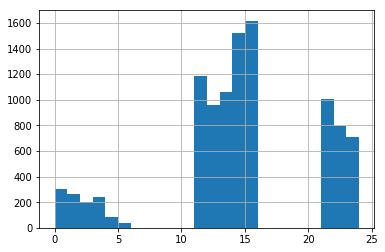

In [115]:
enclosure = dfo.loc[
    (dfo['longitude'] >= xmin) & 
    (dfo['longitude'] <= xmax) & 
    (dfo['latitude'] >= ymin) &
    (dfo['latitude'] <= ymax)
,:].sample(10_000).copy()
enclosure['timestamp'].dt.hour.hist(bins=24, range=[0,24])
plt.show()

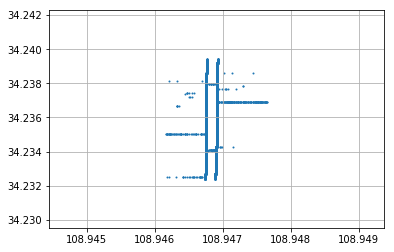

In [10]:
def plot_section(section, zoom=False, filename=None):
    plt.scatter(section['longitude'], section['latitude'], s=1)
    ax = plt.gca()
    if zoom:
        plt.axis([section['longitude'].min(),section['longitude'].max(),section['latitude'].min(),section['latitude'].max()])
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.grid()
    if filename:
        plt.savefig(filename)
    plt.show()

plot_section(enclosure)

Compare with selecting within the timeframe bounds. Notice that not only have points from the link under analysis been removed, but also the links connected to it. Does that mean that the average speeds we're asked to predict also include the other links?

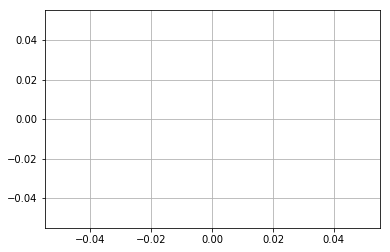

In [61]:
plot_section(enclosure.loc[
    ((enclosure['timestamp'].dt.hour >=  6) & (enclosure['timestamp'].dt.hour < 11)) | 
    ((enclosure['timestamp'].dt.hour >= 16) & (enclosure['timestamp'].dt.hour < 21))
    , :
])

Quoting from the competition `README.md`, "The Predictions_north file includes the average speed of vehicles traveling to north (which means that latitude increasing)" so let's check if there are miniscule differences between latitude values on off-links. Let's zoom in on the top-right east-west link in the bounding box.

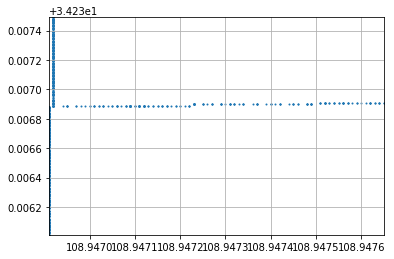

In [12]:
plot_section(enclosure.loc[
    ((enclosure['longitude'] > 108.9469) & (enclosure['longitude'] < 108.948)) & 
    ((enclosure['latitude']  >   34.236) & (enclosure['latitude']  <  34.2375))
    , :
], zoom=True, filename='ex.png')

The steps we see are the precision of the lat-longs, so whenever a vehicle travels past one of those latitude steps on the east-west link, it'll have a non-zero latitude difference and get caught as a northbound or southbound trip unless there is some tolerance for latitude deltas that are close to but not quite zero. Turning timesteps may also be an issue.

Finally we'll compare the bounding box with two small sections just north and south of the study area.

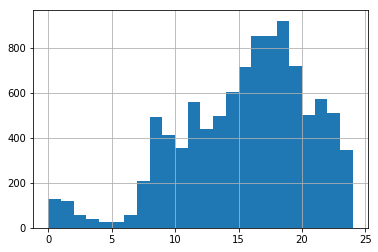

In [13]:
enclosure2 = dfo.loc[
    (dfo['longitude'] > xmin) & 
    (dfo['longitude'] < xmax) & 
    (dfo['latitude'] > ymin-(ymax-ymin)) &
    (dfo['latitude'] < ymin)
,:].sample(10_000)
enclosure2['timestamp'] = pd.to_datetime(enclosure2['timestamp'], unit='s')
enclosure2['timestamp'].dt.hour.hist(bins=24, range=[0,24])
plt.show()

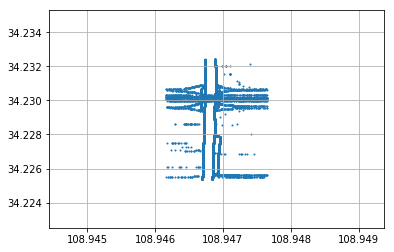

In [14]:
plot_section(enclosure2)

## Find deltas

In [15]:
%%time
dfo.sort_values(['order_id', 'timestamp'], inplace=True)
dfo.reset_index(drop=True, inplace=True)

CPU times: user 9.86 s, sys: 6.41 s, total: 16.3 s
Wall time: 14.3 s


In [16]:
%%time
dfd = pd.concat([dfo.rename(lambda x: x+'1', axis = 1),dfo.shift(-1).rename(lambda x: x+'2', axis = 1)],axis=1)
dfd.drop(dfd[dfd['order_id1'] != dfd['order_id2']].index, inplace=True)
dfd.drop(['order_id1', 'order_id2'], axis=1, inplace=True) # don't need these anymore

CPU times: user 17.9 s, sys: 35.8 s, total: 53.7 s
Wall time: 22.5 s


In [17]:
dfd.head()

,timestamp1,longitude1,latitude1,timestamp2,longitude2,latitude2
0,2016-12-01 04:30:33+08:00,108.94689,34.23261,2016-12-01 04:30:36+08:00,108.94689,34.23261
1,2016-12-01 04:30:36+08:00,108.94689,34.23261,2016-12-01 04:30:39+08:00,108.94689,34.23262
2,2016-12-01 04:30:39+08:00,108.94689,34.23262,2016-12-01 04:30:42+08:00,108.94689,34.23263
3,2016-12-01 04:30:42+08:00,108.94689,34.23263,2016-12-01 04:30:45+08:00,108.94689,34.23266
4,2016-12-01 04:30:45+08:00,108.94689,34.23266,2016-12-01 04:30:48+08:00,108.94690,34.23277


In [18]:
dfd.tail()

,timestamp1,longitude1,latitude1,timestamp2,longitude2,latitude2
23654129,2016-12-01 10:57:36+08:00,108.99623,34.21182,2016-12-01 10:57:39+08:00,108.99654,34.21165
23654130,2016-12-01 10:57:39+08:00,108.99654,34.21165,2016-12-01 10:57:42+08:00,108.99696,34.21141
23654131,2016-12-01 10:57:42+08:00,108.99696,34.21141,2016-12-01 10:57:45+08:00,108.99741,34.21115
23654132,2016-12-01 10:57:45+08:00,108.99741,34.21115,2016-12-01 10:57:48+08:00,108.99776,34.21093
23654133,2016-12-01 10:57:48+08:00,108.99776,34.21093,2016-12-01 10:57:51+08:00,108.99822,34.21059


In [19]:
# verify stuff we have as many steps as we expect
len(dfd) == len(dfo)-len(dfo['order_id'].unique())

True

In [20]:
%%time
# based on provided code
EARTH_RADIUS = 6371*1000  # m
lat1 = np.radians(dfd['latitude1'])
lat2 = np.radians(dfd['latitude2'])
lon1 = np.radians(dfd['longitude1'])
lon2 = np.radians(dfd['longitude2'])
dlat = np.radians(dfd['latitude2']-dfd['latitude1'])
dlon = np.radians(dfd['longitude2']-dfd['longitude1'])
a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) * np.sin(dlon/2)
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
dfd['distance'] = EARTH_RADIUS * c
dfd['speed'] = dfd['distance'] / (dfd['timestamp2'] - dfd['timestamp1']).dt.total_seconds() * 3.6

CPU times: user 3.86 s, sys: 18 s, total: 21.9 s
Wall time: 7.89 s


In [21]:
dfd.head()

,timestamp1,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
0,2016-12-01 04:30:33+08:00,108.94689,34.23261,2016-12-01 04:30:36+08:00,108.94689,34.23261,0.000000,0.000000
1,2016-12-01 04:30:36+08:00,108.94689,34.23261,2016-12-01 04:30:39+08:00,108.94689,34.23262,1.111949,1.334339
2,2016-12-01 04:30:39+08:00,108.94689,34.23262,2016-12-01 04:30:42+08:00,108.94689,34.23263,1.111949,1.334339
3,2016-12-01 04:30:42+08:00,108.94689,34.23263,2016-12-01 04:30:45+08:00,108.94689,34.23266,3.335848,4.003017
4,2016-12-01 04:30:45+08:00,108.94689,34.23266,2016-12-01 04:30:48+08:00,108.94690,34.23277,12.265941,14.719129


## Check speed averaging methodology against predictions.csv 

In [116]:
dfbb = dfd.loc[
    ((dfd['longitude1'] >= xmin) & 
    (dfd['longitude1'] <= xmax) & 
    (dfd['latitude1'] >= ymin) &
    (dfd['latitude1'] <= ymax)) & # |
    ((dfd['longitude2'] >= xmin) & 
    (dfd['longitude2'] <= xmax) & 
    (dfd['latitude2'] >= ymin) &
    (dfd['latitude2'] <= ymax))
,:]
dfbb = dfbb.sort_values("timestamp1")
dfbb.head()

,timestamp1,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
13670954,2016-12-01 00:07:14+08:00,108.9469,34.23413,2016-12-01 00:07:17+08:00,108.9469,34.23413,0.000000,0.000000
13670955,2016-12-01 00:07:17+08:00,108.9469,34.23413,2016-12-01 00:07:20+08:00,108.9469,34.23413,0.000000,0.000000
13670956,2016-12-01 00:07:20+08:00,108.9469,34.23413,2016-12-01 00:07:23+08:00,108.9469,34.23406,7.783645,9.340374
16320567,2016-12-01 00:07:22+08:00,108.9469,34.23291,2016-12-01 00:07:25+08:00,108.9469,34.23340,54.485514,65.382617
13670957,2016-12-01 00:07:23+08:00,108.9469,34.23406,2016-12-01 00:07:26+08:00,108.9469,34.23413,7.783645,9.340374


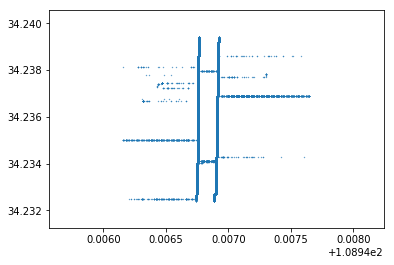

In [117]:
plt.scatter(dfbb['longitude1'], dfbb['latitude1'],s=.1)
plt.show()

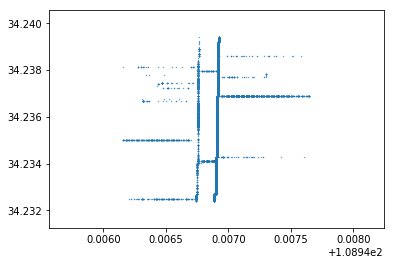

In [353]:
dfbbn = dfbb.loc[dfbb['latitude2']-dfbb['latitude1']>=0,:]
plt.scatter(dfbbn['longitude1'], dfbbn['latitude1'],s=.1)
plt.show()

In [354]:
bb5minN = dfbbn.groupby(pd.Grouper(freq="5T", key="timestamp1")).mean()
bb5minN.head()

,longitude1,latitude1,longitude2,latitude2,distance,speed
timestamp1,,,,,,
2016-12-01 00:05:00+08:00,108.946925,34.236126,108.946923,34.236373,27.692307,32.230014
2016-12-01 00:10:00+08:00,108.946905,34.235384,108.946906,34.235662,31.055461,34.792955
2016-12-01 00:15:00+08:00,108.946905,34.235156,108.946906,34.235481,36.082698,37.778347
2016-12-01 00:20:00+08:00,108.946903,34.235638,108.946908,34.235927,32.329290,37.677478
2016-12-01 00:25:00+08:00,108.946907,34.235652,108.946913,34.235948,33.339441,38.778367


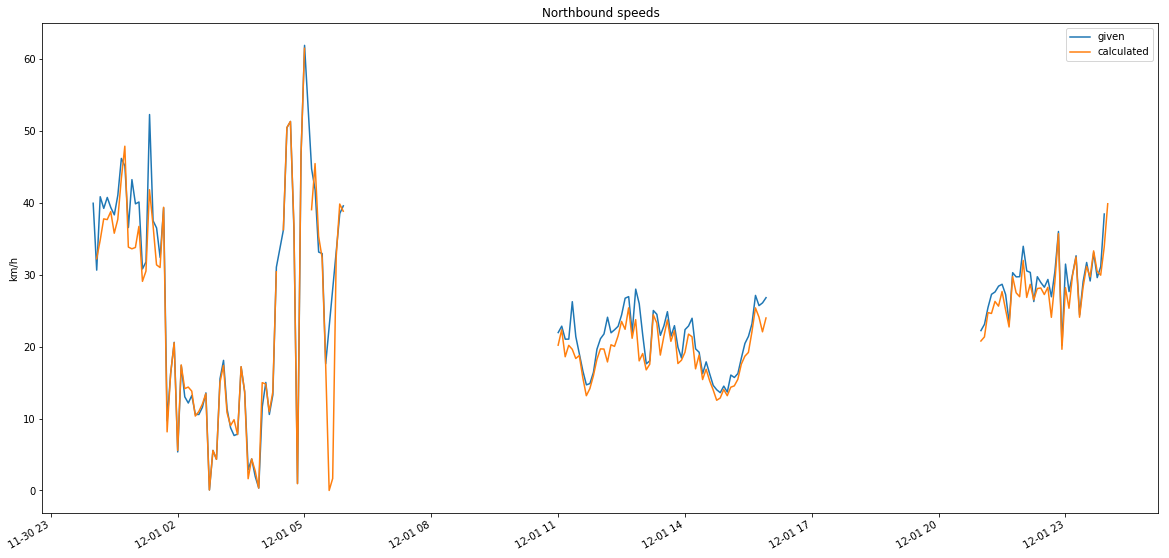

In [355]:
bb5minNtrue = pd.read_csv('Predictions/Predictions_north.csv',index_col='time',parse_dates=True,infer_datetime_format=True,
                          date_parser= lambda x: pd.datetime.strptime(x, '%I:%M:%S %p').replace(year=2016,month=12,day=1))
bb5minNtrue['speed'] = bb5minNtrue['speed'].apply(pd.to_numeric, errors='coerce')
bb5minNtrue.index = bb5minNtrue.index.tz_localize('Asia/Shanghai')
plt.figure(figsize=(20,10))
bb5minNtrue['speed'].plot(label="given")
bb5minN['speed'].plot(label="calculated")
plt.legend()
plt.xlabel('')
plt.title('Northbound speeds')
plt.ylabel('km/h')
plt.savefig('north_average_speeds.png')
plt.show()

Looks like we consistently underestimate the speeds. Let's correct for that.

In [302]:
bb5minN = dfbbn.groupby(pd.Grouper(freq="5T", key="timestamp1", closed="left", label="left", base=0)).mean()
bb5minN.index = bb5minN.index+datetime.timedelta(seconds=5)
for i in np.arange(0,3,.1):
    print(i, ((bb5minNtrue['speed'] - (bb5minN['speed']+i))**2).mean())

0.0 5.581537277316263
0.1 5.337765693974386
0.2 5.113994110632504
0.30000000000000004 4.910222527290627
0.4 4.726450943948743
0.5 4.56267936060686
0.6000000000000001 4.4189077772649785
0.7000000000000001 4.295136193923096
0.8 4.1913646105812195
0.9 4.107593027239339
1.0 4.043821443897455
1.1 4.000049860555572
1.2000000000000002 3.976278277213694
1.3 3.9725066938718134
1.4000000000000001 3.9887351105299302
1.5 4.024963527188053
1.6 4.081191943846169
1.7000000000000002 4.157420360504289
1.8 4.253648777162408
1.9000000000000001 4.369877193820524
2.0 4.506105610478643
2.1 4.662334027136761
2.2 4.838562443794882
2.3000000000000003 5.034790860453
2.4000000000000004 5.25101927711112
2.5 5.487247693769238
2.6 5.743476110427362
2.7 6.019704527085479
2.8000000000000003 6.3159329437435945
2.9000000000000004 6.632161360401714


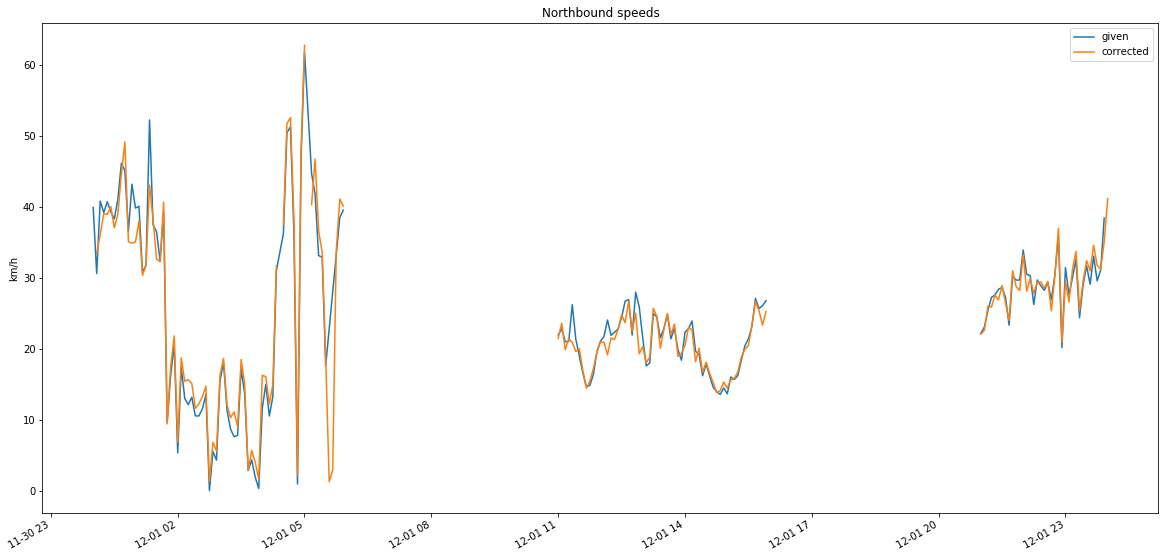

In [303]:
plt.figure(figsize=(20,10))
bb5minNtrue['speed'].plot(label="given")
(bb5minN['speed']+1.3).plot(label="corrected")
plt.legend()
plt.xlabel('')
plt.title('Northbound speeds')
plt.ylabel('km/h')
plt.savefig('north_average_speeds.png')
plt.show()

The early morning speeds now look slightly off but the speeds closer to our target time intervals look much better. Repeat for southbound links.

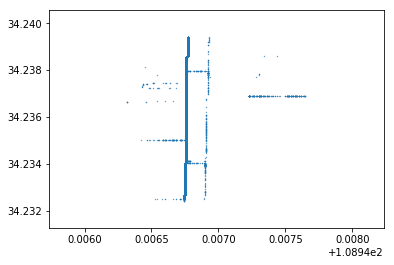

In [227]:
dfbbs = dfbb.loc[dfbb['latitude1']-dfbb['latitude2']>0,:]
plt.scatter(dfbbs['longitude1'], dfbbs['latitude1'],s=.1)
plt.show()

In [269]:
bb5minS = dfbbs.groupby(pd.Grouper(freq="5T", key="timestamp1", closed="left", label="left", base=0)).mean()
bb5minS.head()

,longitude1,latitude1,longitude2,latitude2,distance,speed
timestamp1,,,,,,
2016-12-01 00:05:00+08:00,108.946822,34.237151,108.946804,34.236955,23.050895,26.689675
2016-12-01 00:10:00+08:00,108.946759,34.235711,108.946759,34.235425,31.891962,40.715591
2016-12-01 00:15:00+08:00,108.946766,34.235369,108.946760,34.235115,28.414293,33.193043
2016-12-01 00:20:00+08:00,108.946759,34.236031,108.946758,34.235696,37.322501,43.402590
2016-12-01 00:25:00+08:00,108.946759,34.236260,108.946760,34.235958,33.796694,38.916555


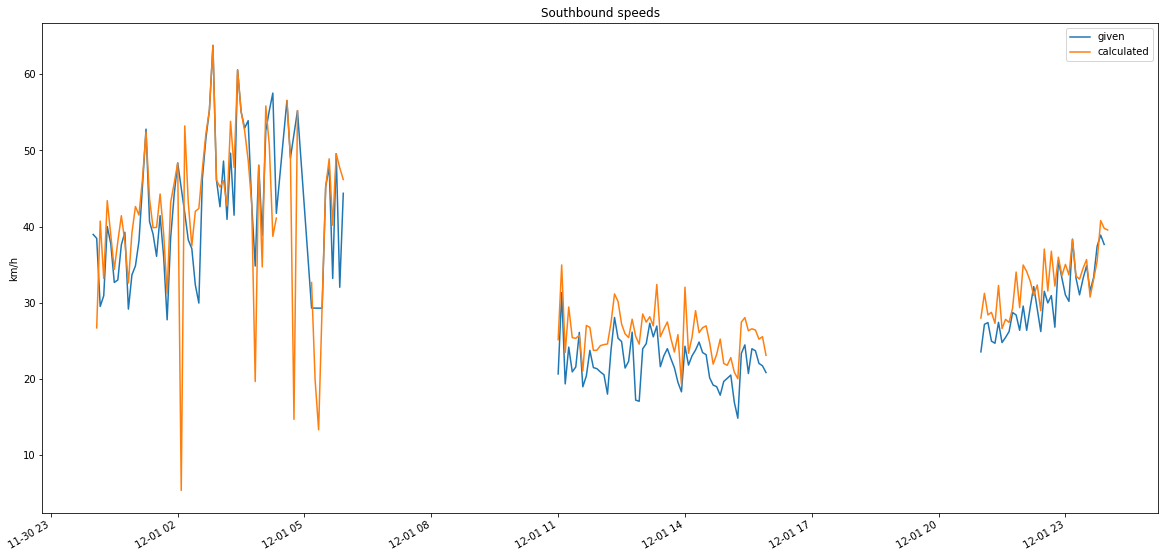

In [291]:
bb5minStrue = pd.read_csv('Predictions/Predictions_south.csv',index_col='time',parse_dates=True,infer_datetime_format=True,
                          date_parser= lambda x: pd.datetime.strptime(x, '%H:%M:%S').replace(year=2016,month=12,day=1))
bb5minStrue['speed'] = bb5minStrue['speed'].apply(pd.to_numeric, errors='coerce')
bb5minStrue.index = bb5minStrue.index.tz_localize('Asia/Shanghai')
plt.figure(figsize=(20,10))
bb5minStrue['speed'].plot(label="given")
bb5minS['speed'].plot(label="calculated")
plt.legend()
plt.xlabel('')
plt.title('Southbound speeds')
plt.ylabel('km/h')
plt.savefig('south_average_speeds.png')
plt.show()

In [288]:
bb5minS = dfbbs.groupby(pd.Grouper(freq="5T", key="timestamp1", closed="left", label="left", base=0)).mean()
bb5minS.index = bb5minS.index+datetime.timedelta(seconds=4)
for i in np.arange(2,4,.1):
    print(i, ((bb5minStrue['speed'] - (bb5minS['speed']-i))**2).mean())

2.0 15.041750859348737
2.1 14.938526943265474
2.2 14.855303027182204
2.3000000000000003 14.792079111098928
2.4000000000000004 14.748855195015658
2.5000000000000004 14.725631278932394
2.6000000000000005 14.722407362849124
2.7000000000000006 14.739183446765862
2.8000000000000007 14.775959530682588
2.900000000000001 14.832735614599327
3.000000000000001 14.909511698516035
3.100000000000001 15.006287782432784
3.200000000000001 15.123063866349513
3.300000000000001 15.259839950266242
3.4000000000000012 15.416616034182981
3.5000000000000013 15.593392118099715
3.6000000000000014 15.790168202016437
3.7000000000000015 16.006944285933166
3.8000000000000016 16.243720369849914
3.9000000000000017 16.500496453766633


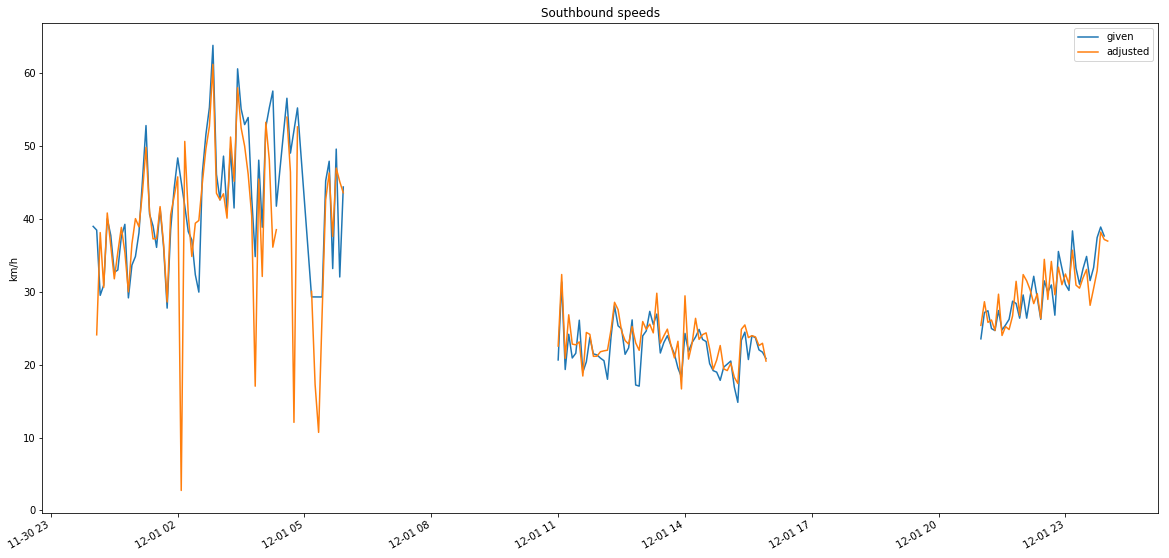

In [289]:
plt.figure(figsize=(20,10))
bb5minStrue['speed'].plot(label="given")
# bb5minS['speed'].plot(label="calculated")
(bb5minS['speed']-2.6).plot(label="adjusted")
plt.legend()
plt.xlabel('')
plt.title('Southbound speeds')
plt.ylabel('km/h')
plt.savefig('south_average_speeds.png')
plt.show()

Also is there a relationship between N and S?

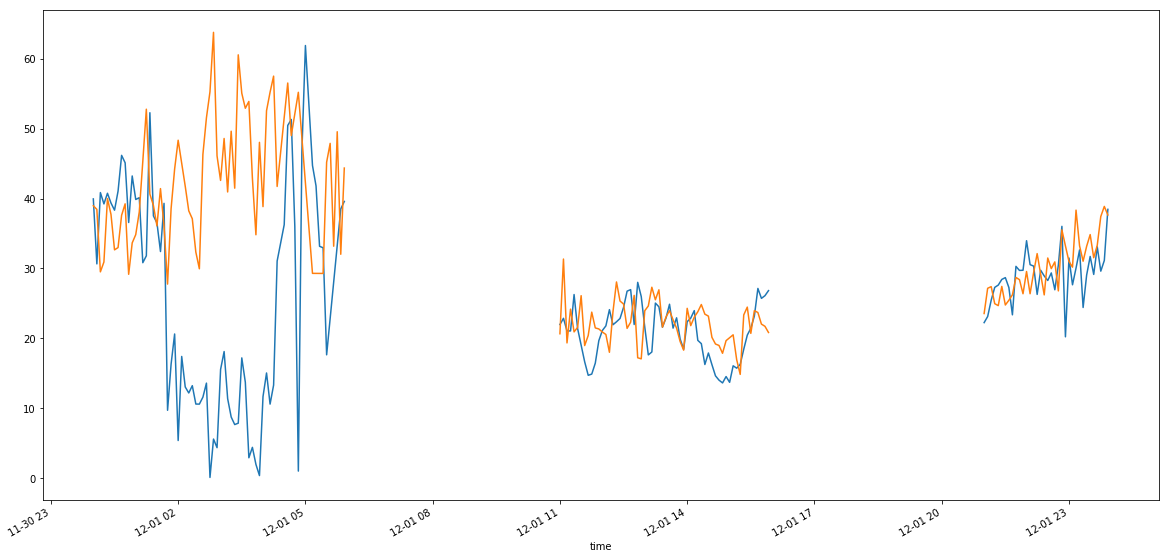

In [348]:
plt.figure(figsize=(20,10))
bb5minNtrue['speed'].plot(label="NB")
bb5minStrue['speed'].plot(label="SB")
plt.show()

Seems like there is. We'll want to interact them.

# Check link segments above and below study area

To see if there are enough datapoints to infer things per time interval

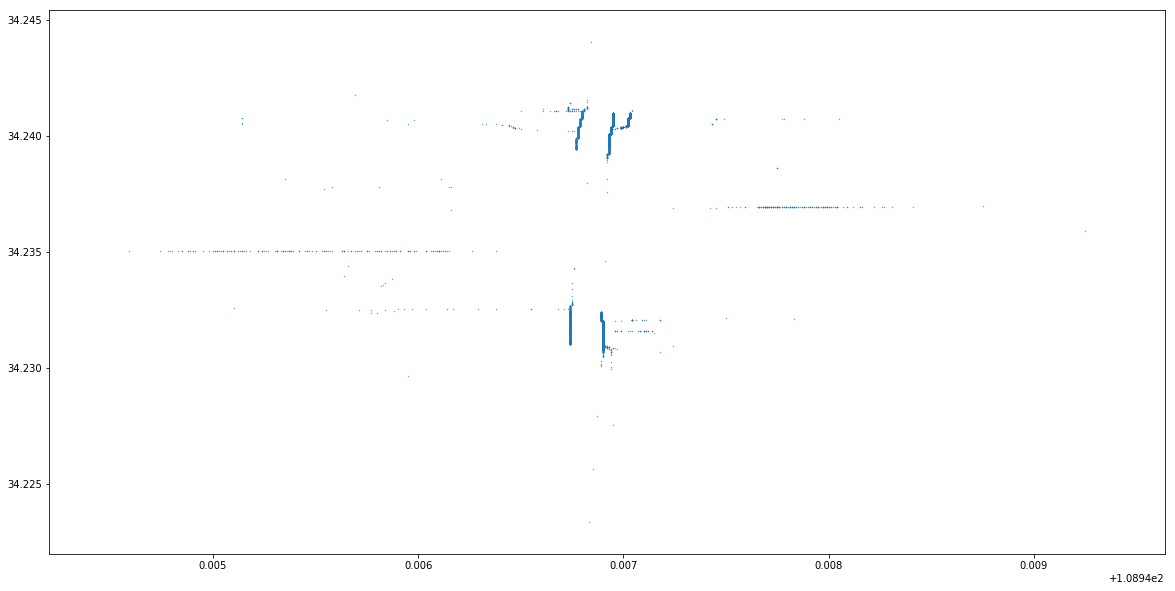

In [58]:
above = 34.241
below = 34.231
left = 108.945
right = 108.948

bigclosure = dfd.loc[
    (((dfd['longitude1'] > left) & 
    (dfd['longitude1'] < right) & 
    (dfd['latitude1'] > below) &
    (dfd['latitude1'] < above)) |
    ((dfd['longitude2'] > left) & 
    (dfd['longitude2'] < right) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < above))) &
    (False == (((dfd['longitude1'] > xmin) & 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > ymin) &
    (dfd['latitude1'] < ymax)) & # |
    ((dfd['longitude2'] > xmin) & 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > ymin) &
    (dfd['latitude2'] < ymax))))
]
temp = bigclosure.sample(10_000)
plt.figure(figsize=(20,10))
plt.scatter(temp['longitude1'], temp['latitude1'], s=.1)
plt.show()

We notice the density of delta points north and south of the study area on the same road are dense, while the points on feeder links east and west of the study area are much more sparse. Let's take a deeper look at these sections in the missing time periods to see if there's enough info to make inferences.

In [62]:
north_nb_am = dfd.loc[
    ((dfd['longitude1'] > xmin) & 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > ymax) &
    (dfd['latitude1'] < above)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
north_nb_am.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:00:00+08:00,70,70,70,70,70,70,70
2016-12-01 06:05:00+08:00,78,78,78,78,78,78,78
2016-12-01 06:10:00+08:00,48,48,48,48,48,48,48
2016-12-01 06:15:00+08:00,42,42,42,42,42,42,42
2016-12-01 06:20:00+08:00,16,16,16,16,16,16,16
2016-12-01 06:25:00+08:00,10,10,10,10,10,10,10
2016-12-01 06:30:00+08:00,23,23,23,23,23,23,23
2016-12-01 06:35:00+08:00,58,58,58,58,58,58,58
2016-12-01 06:40:00+08:00,39,39,39,39,39,39,39


In [63]:
north_sb_am = dfd.loc[
    ((dfd['longitude2'] > xmin) & 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > ymax) &
    (dfd['latitude2'] < above)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
north_sb_am.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:00:00+08:00,70,70,70,70,70,70,70
2016-12-01 06:05:00+08:00,77,77,77,77,77,77,77
2016-12-01 06:10:00+08:00,47,47,47,47,47,47,47
2016-12-01 06:15:00+08:00,42,42,42,42,42,42,42
2016-12-01 06:20:00+08:00,17,17,17,17,17,17,17
2016-12-01 06:25:00+08:00,9,9,9,9,9,9,9
2016-12-01 06:30:00+08:00,23,23,23,23,23,23,23
2016-12-01 06:35:00+08:00,58,58,58,58,58,58,58
2016-12-01 06:40:00+08:00,40,40,40,40,40,40,40


In [65]:
south_sb_am = dfd.loc[
    ((dfd['longitude1'] > xmin) & 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > below) &
    (dfd['latitude1'] < ymin)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
south_sb_am.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:00:00+08:00,13,13,13,13,13,13,13
2016-12-01 06:05:00+08:00,15,15,15,15,15,15,15
2016-12-01 06:10:00+08:00,15,15,15,15,15,15,15
2016-12-01 06:15:00+08:00,12,12,12,12,12,12,12
2016-12-01 06:20:00+08:00,21,21,21,21,21,21,21
2016-12-01 06:25:00+08:00,11,11,11,11,11,11,11
2016-12-01 06:30:00+08:00,10,10,10,10,10,10,10
2016-12-01 06:35:00+08:00,3,3,3,3,3,3,3
2016-12-01 06:40:00+08:00,38,38,38,38,38,38,38


In [78]:
south_nb_am = dfd.loc[
    ((dfd['longitude2'] > xmin) & 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < ymin)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
south_nb_am = south_nb_am.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_nb_am

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:00:00+08:00,15,15,15,15,15,15,15
2016-12-01 06:05:00+08:00,13,13,13,13,13,13,13
2016-12-01 06:10:00+08:00,17,17,17,17,17,17,17
2016-12-01 06:15:00+08:00,12,12,12,12,12,12,12
2016-12-01 06:20:00+08:00,23,23,23,23,23,23,23
2016-12-01 06:25:00+08:00,11,11,11,11,11,11,11
2016-12-01 06:30:00+08:00,11,11,11,11,11,11,11
2016-12-01 06:35:00+08:00,2,2,2,2,2,2,2
2016-12-01 06:40:00+08:00,39,39,39,39,39,39,39


In [67]:
north_nb_pm = dfd.loc[
    ((dfd['longitude1'] > xmin) & 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > ymax) &
    (dfd['latitude1'] < above)) &
    ((dfd['timestamp1'].dt.hour >= 16) & (dfd['timestamp1'].dt.hour < 21))
,:]
north_nb_pm.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 16:00:00+08:00,301,301,301,301,301,301,301
2016-12-01 16:05:00+08:00,364,364,364,364,364,364,364
2016-12-01 16:10:00+08:00,418,418,418,418,418,418,418
2016-12-01 16:15:00+08:00,272,272,272,272,272,272,272
2016-12-01 16:20:00+08:00,430,430,430,430,430,430,430
2016-12-01 16:25:00+08:00,423,423,423,423,423,423,423
2016-12-01 16:30:00+08:00,342,342,342,342,342,342,342
2016-12-01 16:35:00+08:00,282,282,282,282,282,282,282
2016-12-01 16:40:00+08:00,332,332,332,332,332,332,332


In [68]:
north_sb_pm = dfd.loc[
    ((dfd['longitude2'] > xmin) & 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > ymax) &
    (dfd['latitude2'] < above)) &
    ((dfd['timestamp1'].dt.hour >= 16) & (dfd['timestamp1'].dt.hour < 21))
,:]
north_sb_pm.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 16:00:00+08:00,312,312,312,312,312,312,312
2016-12-01 16:05:00+08:00,365,365,365,365,365,365,365
2016-12-01 16:10:00+08:00,412,412,412,412,412,412,412
2016-12-01 16:15:00+08:00,274,274,274,274,274,274,274
2016-12-01 16:20:00+08:00,430,430,430,430,430,430,430
2016-12-01 16:25:00+08:00,417,417,417,417,417,417,417
2016-12-01 16:30:00+08:00,346,346,346,346,346,346,346
2016-12-01 16:35:00+08:00,282,282,282,282,282,282,282
2016-12-01 16:40:00+08:00,335,335,335,335,335,335,335


In [69]:
south_sb_pm = dfd.loc[
    ((dfd['longitude1'] > xmin) & 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > below) &
    (dfd['latitude1'] < ymin)) &
    ((dfd['timestamp1'].dt.hour >= 16) & (dfd['timestamp1'].dt.hour < 21))
,:]
south_sb_pm.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 16:00:00+08:00,197,197,197,197,197,197,197
2016-12-01 16:05:00+08:00,207,207,207,207,207,207,207
2016-12-01 16:10:00+08:00,194,194,194,194,194,194,194
2016-12-01 16:15:00+08:00,111,111,111,111,111,111,111
2016-12-01 16:20:00+08:00,179,179,179,179,179,179,179
2016-12-01 16:25:00+08:00,125,125,125,125,125,125,125
2016-12-01 16:30:00+08:00,180,180,180,180,180,180,180
2016-12-01 16:35:00+08:00,143,143,143,143,143,143,143
2016-12-01 16:40:00+08:00,120,120,120,120,120,120,120


In [70]:
south_nb_pm = dfd.loc[
    ((dfd['longitude2'] > xmin) & 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < ymin)) &
    ((dfd['timestamp1'].dt.hour >= 16) & (dfd['timestamp1'].dt.hour < 21))
,:]
south_nb_pm.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 16:00:00+08:00,194,194,194,194,194,194,194
2016-12-01 16:05:00+08:00,203,203,203,203,203,203,203
2016-12-01 16:10:00+08:00,185,185,185,185,185,185,185
2016-12-01 16:15:00+08:00,115,115,115,115,115,115,115
2016-12-01 16:20:00+08:00,179,179,179,179,179,179,179
2016-12-01 16:25:00+08:00,129,129,129,129,129,129,129
2016-12-01 16:30:00+08:00,177,177,177,177,177,177,177
2016-12-01 16:35:00+08:00,142,142,142,142,142,142,142
2016-12-01 16:40:00+08:00,119,119,119,119,119,119,119


Looks there is plenty above and below the study area to work with, though it gets somewhat tight at 6 am. Let's try the east and west spur links next.

In [71]:
west_am = dfd.loc[
    ((dfd['longitude1'] > left) & 
    (dfd['longitude1'] < xmin) & 
    (dfd['latitude1'] > ymin) &
    (dfd['latitude1'] < ymax)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
west_am.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:45:00+08:00,4,4,4,4,4,4,4
2016-12-01 06:50:00+08:00,9,9,9,9,9,9,9
2016-12-01 06:55:00+08:00,13,13,13,13,13,13,13
2016-12-01 07:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:05:00+08:00,6,6,6,6,6,6,6
2016-12-01 07:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:15:00+08:00,3,3,3,3,3,3,3
2016-12-01 07:20:00+08:00,10,10,10,10,10,10,10
2016-12-01 07:25:00+08:00,0,0,0,0,0,0,0


In [72]:
east_am = dfd.loc[
    ((dfd['longitude1'] > xmax) & 
    (dfd['longitude1'] < right) & 
    (dfd['latitude1'] > ymin) &
    (dfd['latitude1'] < ymax)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
east_am.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:15:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:20:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:25:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:30:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:35:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:40:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:45:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:50:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:55:00+08:00,1,1,1,1,1,1,1


For most of these intervals there's not enough information to work with, so our model will focus only on the interactions north and south of the dataset. Alternatively, we can infer that there are few-to-no vehicles on those links and thus they're moving at free-flow speed.

Next, let's segment the model into movement categories:
1. deltas that start and end in the north/south segment
2. deltas that cross the intersection
3. deltas that make a right turn into the segment
4. deltas that make a left turn into the segment

and define tighter bounds for the road segment to distinguish between rights, lefts, and straights.

In [158]:
# longitude bounds for only the north-south link
left_only = 108.94668
right_only = 108.9471

In [79]:
south_nb_am_in = dfd.loc[
    ((dfd['longitude2'] > xmin) & # ends at the road segment south of the study area 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < ymin)) & 
    ((dfd['longitude1'] > xmin) & # starts on the same segment
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > below) &
    (dfd['latitude1'] < ymin)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_nb_am_in

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:00:00+08:00,9,9,9,9,9,9,9
2016-12-01 06:05:00+08:00,9,9,9,9,9,9,9
2016-12-01 06:10:00+08:00,12,12,12,12,12,12,12
2016-12-01 06:15:00+08:00,9,9,9,9,9,9,9
2016-12-01 06:20:00+08:00,19,19,19,19,19,19,19
2016-12-01 06:25:00+08:00,8,8,8,8,8,8,8
2016-12-01 06:30:00+08:00,8,8,8,8,8,8,8
2016-12-01 06:35:00+08:00,2,2,2,2,2,2,2
2016-12-01 06:40:00+08:00,34,34,34,34,34,34,34


In [80]:
south_nb_am_in['speed']/south_nb_am['speed']

timestamp1
2016-12-01 06:00:00+08:00    0.600000
2016-12-01 06:05:00+08:00    0.692308
2016-12-01 06:10:00+08:00    0.705882
2016-12-01 06:15:00+08:00    0.750000
2016-12-01 06:20:00+08:00    0.826087
2016-12-01 06:25:00+08:00    0.727273
2016-12-01 06:30:00+08:00    0.727273
2016-12-01 06:35:00+08:00    1.000000
2016-12-01 06:40:00+08:00    0.871795
2016-12-01 06:45:00+08:00    0.820513
2016-12-01 06:50:00+08:00    0.795455
2016-12-01 06:55:00+08:00    0.814815
2016-12-01 07:00:00+08:00    0.761905
2016-12-01 07:05:00+08:00    0.714286
2016-12-01 07:10:00+08:00    0.771429
2016-12-01 07:15:00+08:00    0.723404
2016-12-01 07:20:00+08:00    0.857143
2016-12-01 07:25:00+08:00    0.813953
2016-12-01 07:30:00+08:00    0.828571
2016-12-01 07:35:00+08:00    0.781250
2016-12-01 07:40:00+08:00    0.837500
2016-12-01 07:45:00+08:00    0.781818
2016-12-01 07:50:00+08:00    0.817308
2016-12-01 07:55:00+08:00    0.889655
2016-12-01 08:00:00+08:00    0.898089
2016-12-01 08:05:00+08:00    0.914894
2

The vast majority of deltas start and end in the same section(!).

In [108]:
south_nb_am_x = dfd.loc[
    ((dfd['longitude2'] > xmin) & # ends at the road segment south of the study area 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < ymin)) & 
    ((dfd['longitude1'] >= left_only) & # starts in or across the intersection on the same road
    (dfd['longitude1'] <= right_only) & 
    (dfd['latitude1'] < below)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_nb_am_x

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:00:00+08:00,3,3,3,3,3,3,3
2016-12-01 06:05:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:10:00+08:00,4,4,4,4,4,4,4
2016-12-01 06:15:00+08:00,3,3,3,3,3,3,3
2016-12-01 06:20:00+08:00,3,3,3,3,3,3,3
2016-12-01 06:25:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:30:00+08:00,2,2,2,2,2,2,2
2016-12-01 06:35:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:40:00+08:00,4,4,4,4,4,4,4


In [109]:
south_nb_am_x['speed']/south_nb_am['speed']

timestamp1
2016-12-01 06:00:00+08:00    0.200000
2016-12-01 06:05:00+08:00    0.000000
2016-12-01 06:10:00+08:00    0.235294
2016-12-01 06:15:00+08:00    0.250000
2016-12-01 06:20:00+08:00    0.130435
2016-12-01 06:25:00+08:00    0.090909
2016-12-01 06:30:00+08:00    0.181818
2016-12-01 06:35:00+08:00    0.000000
2016-12-01 06:40:00+08:00    0.102564
2016-12-01 06:45:00+08:00    0.102564
2016-12-01 06:50:00+08:00    0.113636
2016-12-01 06:55:00+08:00    0.111111
2016-12-01 07:00:00+08:00    0.214286
2016-12-01 07:05:00+08:00    0.142857
2016-12-01 07:10:00+08:00    0.142857
2016-12-01 07:15:00+08:00    0.106383
2016-12-01 07:20:00+08:00    0.142857
2016-12-01 07:25:00+08:00    0.162791
2016-12-01 07:30:00+08:00    0.128571
2016-12-01 07:35:00+08:00    0.125000
2016-12-01 07:40:00+08:00    0.112500
2016-12-01 07:45:00+08:00    0.127273
2016-12-01 07:50:00+08:00    0.115385
2016-12-01 07:55:00+08:00    0.082759
2016-12-01 08:00:00+08:00    0.038217
2016-12-01 08:05:00+08:00    0.063830
2

In [110]:
(south_nb_am_in['speed']+south_nb_am_x['speed'])/south_nb_am['speed']

timestamp1
2016-12-01 06:00:00+08:00    0.800000
2016-12-01 06:05:00+08:00    0.692308
2016-12-01 06:10:00+08:00    0.941176
2016-12-01 06:15:00+08:00    1.000000
2016-12-01 06:20:00+08:00    0.956522
2016-12-01 06:25:00+08:00    0.818182
2016-12-01 06:30:00+08:00    0.909091
2016-12-01 06:35:00+08:00    1.000000
2016-12-01 06:40:00+08:00    0.974359
2016-12-01 06:45:00+08:00    0.923077
2016-12-01 06:50:00+08:00    0.909091
2016-12-01 06:55:00+08:00    0.925926
2016-12-01 07:00:00+08:00    0.976190
2016-12-01 07:05:00+08:00    0.857143
2016-12-01 07:10:00+08:00    0.914286
2016-12-01 07:15:00+08:00    0.829787
2016-12-01 07:20:00+08:00    1.000000
2016-12-01 07:25:00+08:00    0.976744
2016-12-01 07:30:00+08:00    0.957143
2016-12-01 07:35:00+08:00    0.906250
2016-12-01 07:40:00+08:00    0.950000
2016-12-01 07:45:00+08:00    0.909091
2016-12-01 07:50:00+08:00    0.932692
2016-12-01 07:55:00+08:00    0.972414
2016-12-01 08:00:00+08:00    0.936306
2016-12-01 08:05:00+08:00    0.978723
2

So it seems that south-to-north traffic accounts for 80-100% of flow on this link segment. There's very little flow left to account for. What about deltas simply crossing the bbox entirely?

In [129]:
south_nb_am_os = dfd.loc[
    ((dfd['longitude2'] > xmin) & # ends at the road segment south of the study area 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < ymin)) & 
    ((dfd['longitude1'] > xmin) & # starts on the other side of the study area
    (dfd['longitude1'] < xmax) &
    (dfd['latitude1'] > ymin) &
    (dfd['latitude1'] < above)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_nb_am_os

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:00:00+08:00,3,3,3,3,3,3,3
2016-12-01 06:05:00+08:00,4,4,4,4,4,4,4
2016-12-01 06:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:15:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:20:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:25:00+08:00,2,2,2,2,2,2,2
2016-12-01 06:30:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:35:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:40:00+08:00,1,1,1,1,1,1,1


In [130]:
south_nb_am_osa = dfd.loc[
    ((dfd['longitude2'] > xmin) & # ends at the road segment south of the study area 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < ymin)) & 
    ((dfd['longitude1'] > xmin) & # starts on the other side of the study area, past the link segment
    (dfd['longitude1'] < xmax) &
    (dfd['latitude1'] > above)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_nb_am_osa

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 09:50:00+08:00,1,1,1,1,1,1,1
2016-12-01 09:55:00+08:00,1,1,1,1,1,1,1


In [131]:
(south_nb_am_in['speed']+south_nb_am_x['speed']+south_nb_am_os['speed'])/south_nb_am['speed']

timestamp1
2016-12-01 06:00:00+08:00    1.000000
2016-12-01 06:05:00+08:00    1.000000
2016-12-01 06:10:00+08:00    0.941176
2016-12-01 06:15:00+08:00    1.000000
2016-12-01 06:20:00+08:00    1.000000
2016-12-01 06:25:00+08:00    1.000000
2016-12-01 06:30:00+08:00    1.000000
2016-12-01 06:35:00+08:00    1.000000
2016-12-01 06:40:00+08:00    1.000000
2016-12-01 06:45:00+08:00    0.974359
2016-12-01 06:50:00+08:00    0.977273
2016-12-01 06:55:00+08:00    0.925926
2016-12-01 07:00:00+08:00    1.000000
2016-12-01 07:05:00+08:00    0.928571
2016-12-01 07:10:00+08:00    0.971429
2016-12-01 07:15:00+08:00    0.978723
2016-12-01 07:20:00+08:00    1.000000
2016-12-01 07:25:00+08:00    1.000000
2016-12-01 07:30:00+08:00    1.000000
2016-12-01 07:35:00+08:00    0.968750
2016-12-01 07:40:00+08:00    0.975000
2016-12-01 07:45:00+08:00    0.963636
2016-12-01 07:50:00+08:00    0.961538
2016-12-01 07:55:00+08:00    0.979310
2016-12-01 08:00:00+08:00    0.968153
2016-12-01 08:05:00+08:00    0.985816
2

So there's very little to learn from turning movements and it turns out that almost all of the remaining flow we thought was northbound on the southern section was actually _southbound_ traffic that ended up on this section, crossing the bbox entirely. This might be explained if these deltas crossing the bbox have a higher timestamp difference than other movements, which would align with the assumption that the dataset was created by just excising points in the area of study but leaving trajectories the same otherwise. This will also need to be reflected in the data processing step.

In [135]:
south_nb_am_l = dfd.loc[
    ((dfd['longitude2'] > xmin) & # ends at the road segment south of the study area 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < ymin)) & 
    ((dfd['longitude1'] < left_only) & # turns left into segment 
    (dfd['latitude1'] < below)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_nb_am_l

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 08:55:00+08:00,1,1,1,1,1,1,1
2016-12-01 09:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:05:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:15:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:20:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:25:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:30:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:35:00+08:00,0,0,0,0,0,0,0


In [136]:
south_nb_am_r = dfd.loc[
    ((dfd['longitude2'] > xmin) & # ends at the road segment south of the study area 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > below) &
    (dfd['latitude2'] < ymin)) & 
    ((dfd['longitude1'] > right_only) & # turns right into segment 
    (dfd['latitude1'] < below)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_nb_am_r

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 07:40:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:45:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:50:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:55:00+08:00,1,1,1,1,1,1,1
2016-12-01 08:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 08:05:00+08:00,1,1,1,1,1,1,1
2016-12-01 08:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 08:15:00+08:00,0,0,0,0,0,0,0
2016-12-01 08:20:00+08:00,0,0,0,0,0,0,0


So we have next to no information about turning movements (at least on this link section). How about another one, say, links that start in the southern section and turn off the link?

In [139]:
south_sb_am_l = dfd.loc[
    ((dfd['longitude1'] > xmin) & # starts at the road segment south of the study area 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > below) &
    (dfd['latitude1'] < ymin)) & 
    ((dfd['longitude2'] >= right_only) & # turns left out of segment 
    (dfd['latitude2'] < below)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_sb_am_l

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,


In [159]:
south_sb_am_r_dat = dfd.loc[
    ((dfd['longitude1'] > xmin) & # starts at the road segment south of the study area 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > below) &
    (dfd['latitude1'] < ymin)) & 
    ((dfd['longitude2'] <= left_only) & # turns right out of segment 
    (dfd['latitude2'] < below)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
south_sb_am_r = south_sb_am_r_dat.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
south_sb_am_r

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:40:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:45:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:50:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:55:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:05:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:15:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:20:00+08:00,1,1,1,1,1,1,1


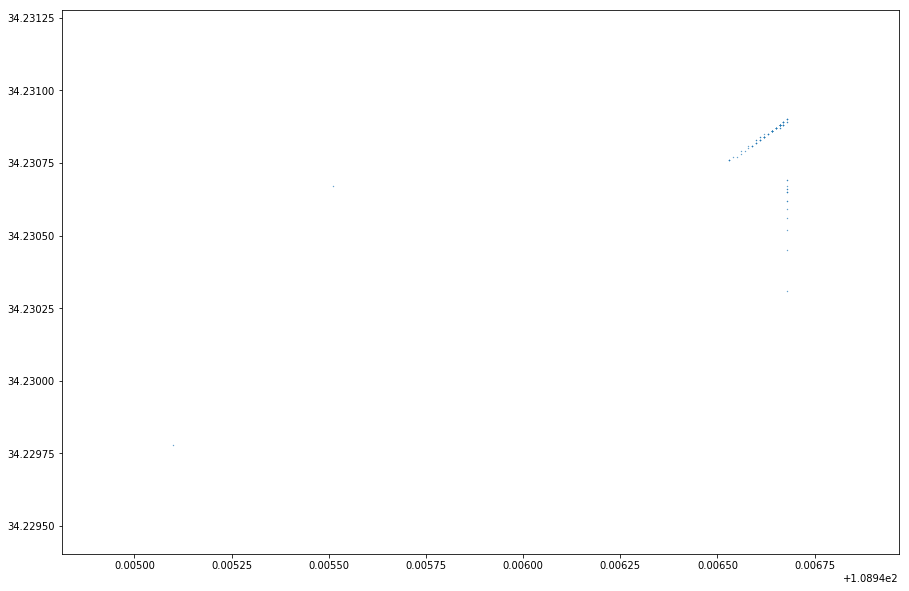

In [160]:
plt.figure(figsize=(15,10))
plt.scatter(south_sb_am_r_dat['longitude2'], south_sb_am_r_dat['latitude2'], s=.1)
plt.show()

So the southbound right turn encompasses vehicles heading to both east- and westbound on the second ring road via on-ramps.

Does this hold true for the northern link section as well?

In [140]:
north_nb_am_r = dfd.loc[
    ((dfd['longitude1'] > xmin) & # starts at the road segment north of the study area 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > ymax) &
    (dfd['latitude1'] < above)) & 
    ((dfd['longitude2'] >= right_only) & # turns right out of segment 
    (dfd['latitude2'] > above)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
north_nb_am_r

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 07:10:00+08:00,2,2,2,2,2,2,2
2016-12-01 07:15:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:20:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:25:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:30:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:35:00+08:00,2,2,2,2,2,2,2
2016-12-01 07:40:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:45:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:50:00+08:00,1,1,1,1,1,1,1


In [141]:
north_nb_am_l = dfd.loc[
    ((dfd['longitude1'] > xmin) & # start at the road segment north of the study area 
    (dfd['longitude1'] < xmax) & 
    (dfd['latitude1'] > ymax) &
    (dfd['latitude1'] < above)) & 
    ((dfd['longitude2'] <= left_only) & # turns left out of segment 
    (dfd['latitude2'] > above)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
north_nb_am_l

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 08:30:00+08:00,1,1,1,1,1,1,1
2016-12-01 08:35:00+08:00,0,0,0,0,0,0,0
2016-12-01 08:40:00+08:00,0,0,0,0,0,0,0
2016-12-01 08:45:00+08:00,0,0,0,0,0,0,0
2016-12-01 08:50:00+08:00,0,0,0,0,0,0,0
2016-12-01 08:55:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:00:00+08:00,1,1,1,1,1,1,1
2016-12-01 09:05:00+08:00,0,0,0,0,0,0,0
2016-12-01 09:10:00+08:00,1,1,1,1,1,1,1


Vehicles leaving the study link we see more rights than lefts but in total very few of either. What about vehicles turning into the link?

In [142]:
north_sb_am_l = dfd.loc[
    ((dfd['longitude2'] > xmin) & # ends at the road segment north of the study area 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > ymax) &
    (dfd['latitude2'] < above)) & 
    ((dfd['longitude1'] >= right_only) & # turns left into segment 
    (dfd['latitude1'] > above)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
north_sb_am_l

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,


In [143]:
north_sb_am_r = dfd.loc[
    ((dfd['longitude2'] > xmin) & # ends at the road segment north of the study area 
    (dfd['longitude2'] < xmax) & 
    (dfd['latitude2'] > ymax) &
    (dfd['latitude2'] < above)) & 
    ((dfd['longitude1'] <= left_only) & # turns right into segment 
    (dfd['latitude1'] > above)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:].sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()
north_sb_am_r

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:05:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:15:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:20:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:25:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:30:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:35:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:40:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:45:00+08:00,0,0,0,0,0,0,0


So it seems the only turning motion with a somewhat significant amount of information is vehicles in the southern section, southbound, turning right off of the link.

Let's also check the spur links to the west and east of the study area for significance.

In [312]:
ew_bbox = dfd.loc[
    (((dfd['longitude1'] < xmin) &  # starts either east/west of study area
    (dfd['longitude1'] > 108.940)) |
    ((dfd['longitude1'] > xmax) &
    (dfd['longitude1'] < 108.9487))) & 
    (((dfd['longitude2'] < xmin) &  # ends either east/west of study area
    (dfd['longitude2'] > 108.940)) |
    ((dfd['longitude2'] > xmax) &
    (dfd['longitude2'] < 108.9487))) &
    (((dfd['latitude1'] > ymin) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < ymax)) | 
    ((dfd['latitude2'] > ymin) &
    (dfd['latitude2'] < ymax))) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
ew_bbox.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:00:00+08:00,12,12,12,12,12,12,12
2016-12-01 06:05:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:15:00+08:00,2,2,2,2,2,2,2
2016-12-01 06:20:00+08:00,7,7,7,7,7,7,7
2016-12-01 06:25:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:30:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:35:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:40:00+08:00,11,11,11,11,11,11,11


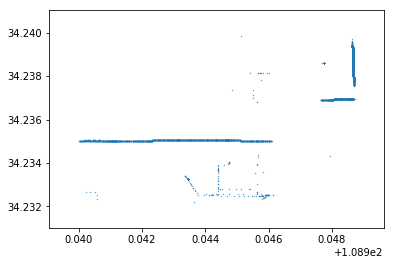

In [313]:
plt.scatter(ew_bbox['longitude1'],ew_bbox['latitude1'],s=.1)
plt.show()

So the more northern west link and the eastern link have significant flow. What happens if we break them down?

In [215]:
w_bbox_eb = dfd.loc[
    ((dfd['longitude1'] < xmin) &  # starts either east/west of study area
    (dfd['longitude1'] > 108.9393)) &
    ((dfd['latitude1'] > 34.2345) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < 34.2355)) &
    ((dfd['longitude2'] < xmin) &  # starts either east/west of study area
    (dfd['longitude2'] > 108.9393)) &
    ((dfd['latitude2'] > 34.2345) & # starts and ends at the same latitude as bbox
    (dfd['latitude2'] < 34.2355)) &
    (dfd['longitude1'] < dfd['longitude2']) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
w_bbox_eb.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:45:00+08:00,22,22,22,22,22,22,22
2016-12-01 06:50:00+08:00,21,21,21,21,21,21,21
2016-12-01 06:55:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:05:00+08:00,32,32,32,32,32,32,32
2016-12-01 07:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:15:00+08:00,37,37,37,37,37,37,37
2016-12-01 07:20:00+08:00,13,13,13,13,13,13,13
2016-12-01 07:25:00+08:00,0,0,0,0,0,0,0


In [216]:
w_bbox_wb = dfd.loc[
    ((dfd['longitude1'] < xmin) &  # starts either east/west of study area
    (dfd['longitude1'] > 108.9393)) &
    ((dfd['latitude1'] > 34.2345) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < 34.2355)) &
    ((dfd['longitude2'] < xmin) &  # starts either east/west of study area
    (dfd['longitude2'] > 108.9393)) &
    ((dfd['latitude2'] > 34.2345) & # starts and ends at the same latitude as bbox
    (dfd['latitude2'] < 34.2355)) &
    (dfd['longitude1'] > dfd['longitude2']) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
w_bbox_wb.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 07:25:00+08:00,11,11,11,11,11,11,11
2016-12-01 07:30:00+08:00,13,13,13,13,13,13,13
2016-12-01 07:35:00+08:00,29,29,29,29,29,29,29
2016-12-01 07:40:00+08:00,12,12,12,12,12,12,12
2016-12-01 07:45:00+08:00,10,10,10,10,10,10,10
2016-12-01 07:50:00+08:00,33,33,33,33,33,33,33
2016-12-01 07:55:00+08:00,21,21,21,21,21,21,21
2016-12-01 08:00:00+08:00,19,19,19,19,19,19,19
2016-12-01 08:05:00+08:00,0,0,0,0,0,0,0


In [304]:
w_bbox_nm = dfd.loc[
    ((dfd['longitude1'] < xmin) &  # starts either east/west of study area
    (dfd['longitude1'] > 108.9393)) &
    ((dfd['latitude1'] > 34.2345) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < 34.2355)) &
    ((dfd['longitude2'] < xmin) &  # starts either east/west of study area
    (dfd['longitude2'] > 108.9393)) &
    ((dfd['latitude2'] > 34.2345) & # starts and ends at the same latitude as bbox
    (dfd['latitude2'] < 34.2355)) &
    (dfd['latitude1'] == dfd['latitude2']) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
w_bbox_nm.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:45:00+08:00,14,14,14,14,14,14,14
2016-12-01 06:50:00+08:00,13,13,13,13,13,13,13
2016-12-01 06:55:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:05:00+08:00,24,24,24,24,24,24,24
2016-12-01 07:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:15:00+08:00,29,29,29,29,29,29,29
2016-12-01 07:20:00+08:00,17,17,17,17,17,17,17
2016-12-01 07:25:00+08:00,18,18,18,18,18,18,18


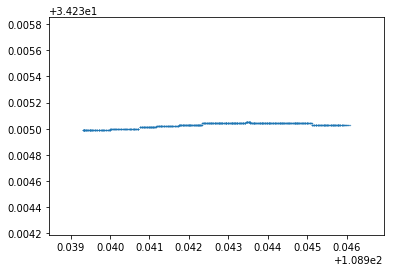

In [305]:
plt.scatter(w_bbox_eb['longitude1'],w_bbox_eb['latitude1'],s=.1)
plt.show()

There seems to be enough information on the east and west-bound links to be useful. What about for the other feeder road on the east side?

In [337]:
e_bbox_eb = dfd.loc[
    ((dfd['longitude1'] > xmax) &  # starts either east/west of study area
    (dfd['longitude1'] < 108.9486)) &
    ((dfd['latitude1'] > 34.236) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < 34.237)) &
    ((dfd['longitude2'] > xmax) &  # starts either east/west of study area
    (dfd['longitude2'] < 108.9486)) &
    ((dfd['latitude2'] > 34.236) & # starts and ends at the same latitude as bbox
    (dfd['latitude2'] < 34.237)) &
    (dfd['longitude1'] < dfd['longitude2']) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
e_bbox_eb.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:15:00+08:00,2,2,2,2,2,2,2
2016-12-01 06:20:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:25:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:30:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:35:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:40:00+08:00,2,2,2,2,2,2,2
2016-12-01 06:45:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:50:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:55:00+08:00,0,0,0,0,0,0,0


In [339]:
e_bbox_wb = dfd.loc[
    ((dfd['longitude1'] > xmax) &  # starts either east/west of study area
    (dfd['longitude1'] < 108.9486)) &
    ((dfd['latitude1'] > 34.236) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < 34.237)) &
    ((dfd['longitude2'] > xmax) &  # starts either east/west of study area
    (dfd['longitude2'] < 108.9486)) &
    ((dfd['latitude2'] > 34.236) & # starts and ends at the same latitude as bbox
    (dfd['latitude2'] < 34.237)) &
    (dfd['longitude1'] > dfd['longitude2']) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
e_bbox_wb.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:55:00+08:00,3,3,3,3,3,3,3
2016-12-01 07:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:05:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:10:00+08:00,6,6,6,6,6,6,6
2016-12-01 07:15:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:20:00+08:00,3,3,3,3,3,3,3
2016-12-01 07:25:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:30:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:35:00+08:00,10,10,10,10,10,10,10


In [341]:
e_bbox_nm = dfd.loc[
    ((dfd['longitude1'] > xmax) &  # starts either east/west of study area
    (dfd['longitude1'] < 108.9486)) &
    ((dfd['latitude1'] > 34.236) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < 34.237)) &
    ((dfd['longitude2'] > xmax) &  # starts either east/west of study area
    (dfd['longitude2'] < 108.9486)) &
    ((dfd['latitude2'] > 34.236) & # starts and ends at the same latitude as bbox
    (dfd['latitude2'] < 34.237)) &
    (dfd['longitude1'] == dfd['longitude2']) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
e_bbox_nm.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:55:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:05:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:10:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:15:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:20:00+08:00,2,2,2,2,2,2,2
2016-12-01 07:25:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:30:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:35:00+08:00,3,3,3,3,3,3,3


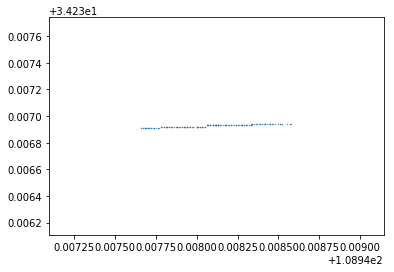

In [338]:
plt.scatter(e_bbox_eb['longitude1'],e_bbox_eb['latitude1'],s=.1)
plt.show()

There seems to be enough information to use here as well.

How often do we see vehicles from these feeder links cross the study area?

In [342]:
a = dfd.loc[
    ((dfd['longitude1'] > xmax) &  # starts either east/west of study area
    (dfd['longitude1'] < 108.9486)) &
    ((dfd['latitude1'] > 34.236) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < 34.237)) &
    ((dfd['longitude2'] < xmax) &  # starts either east/west of study area
    (dfd['longitude2'] > xmin)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
a.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:55:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:05:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:10:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:15:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:20:00+08:00,2,2,2,2,2,2,2
2016-12-01 07:25:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:30:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:35:00+08:00,3,3,3,3,3,3,3


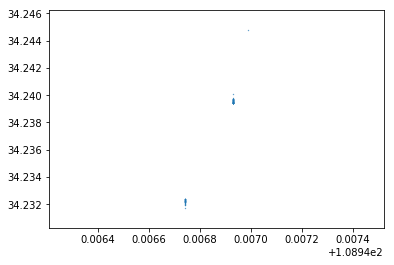

In [343]:
plt.scatter(a['longitude2'],a['latitude2'],s=.1)
plt.show()

In [345]:
b = dfd.loc[
    ((dfd['longitude1'] < xmin) &  # starts either east/west of study area
    (dfd['longitude1'] > 108.9393)) &
    ((dfd['latitude1'] > 34.2345) & # starts and ends at the same latitude as bbox
    (dfd['latitude1'] < 34.2355)) &
    ((dfd['longitude2'] < xmax) &  # starts either east/west of study area
    (dfd['longitude2'] > xmin)) &
    ((dfd['timestamp1'].dt.hour >= 6) & (dfd['timestamp1'].dt.hour < 11))
,:]
b.sort_values("timestamp1").groupby(pd.Grouper(freq="5T", key="timestamp1")).count()

,longitude1,latitude1,timestamp2,longitude2,latitude2,distance,speed
timestamp1,,,,,,,
2016-12-01 06:45:00+08:00,1,1,1,1,1,1,1
2016-12-01 06:50:00+08:00,0,0,0,0,0,0,0
2016-12-01 06:55:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:00:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:05:00+08:00,1,1,1,1,1,1,1
2016-12-01 07:10:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:15:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:20:00+08:00,0,0,0,0,0,0,0
2016-12-01 07:25:00+08:00,0,0,0,0,0,0,0


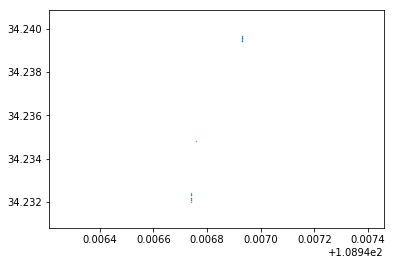

In [346]:
plt.scatter(b['longitude2'],b['latitude2'],s=.1)
plt.show()

There are a few data points but not enough to work with. So we'll look at links traveling from the following mutually exclusive areas:

* N: north of the study area, south of the northern intersection
* NN: north of the study area, including and past the northern intersection
* W: the (more northern) feeder link west of the study area
* E: the feeder link east of the study area
* S: south of the study area, north of the southern intersection
* SS: south of the study area, including and past the southern intersection

Movements we'll consider as influencing either northbound or southbound average speeds are:
* Northbound
    * n_n_nb: N -> N northbound
    * n_nn: N -> NN
    * s_n: S -> N
    * s_s_nb: S -> S northbound
    * ss_s: SS -> S
* Southbound
    * n_n_sb: N -> N southbound
    * nn_n: NN -> N
    * n_s: N -> S
    * s_s_sb: S -> S southbound
    * s_ss: S -> SS
* Both
    * w_w_eb: W -> W eastbound
    * w_w_wb: W -> W westbound
    * e_e_eb: E -> E eastbound
    * e_e_wb: E -> E westbound

For same area to same area movements, we'll take half of non-moving deltas (where we can't determine directionality) and assign them to each direction.

Averaging speeds for each movement across a 5-minute interval (and replacing intervals without enough information), we'll fit some function of the above (and perhaps some exogenous variables) to the observed average southbound and northbound travel times in the intersection. If there is not enough information on an interval for an average, we'll replace the missing average with the maximum average speed observed on an interval (with the implication being that no traffic means that traffic is moving at free-flow speed).